In [3]:
import os
import pandas as pd
import numpy as np

os.getcwd()

'/content'

In [4]:
os.chdir("/content/drive/MyDrive/Learning/bigspring_assignment/twitter_cs/")
os.getcwd()

'/content/drive/MyDrive/Learning/bigspring_assignment/twitter_cs'

In [5]:
sample_df = pd.read_csv("twcs/twcs.csv")
sample_df.set_index("tweet_id", inplace=True)
sample_df.head()
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2811774 entries, 1 to 2987950
Data columns (total 6 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   author_id                object 
 1   inbound                  bool   
 2   created_at               object 
 3   text                     object 
 4   response_tweet_id        object 
 5   in_response_to_tweet_id  float64
dtypes: bool(1), float64(1), object(4)
memory usage: 131.4+ MB


In [6]:
query_df = sample_df[sample_df.in_response_to_tweet_id.isna()]
query_df['text'] = query_df['text'].fillna("")
query_df["followup"]=""
query_df["solution"]=""
query_df["customer_handle"]=""

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [7]:
def find_relevant_ids(row):
  ref_tweet_ids=[]
  r_tweet_id = row.response_tweet_id
  if type(r_tweet_id) == str:
    ref_tweet_ids=str(r_tweet_id).split(",")
    ref_tweet_ids=list(map(int,ref_tweet_ids))
  return ref_tweet_ids

def update_followup(row):
  global sample_df
  customer_handle_to_find = True

  ref_tweet_ids=find_relevant_ids(row)
  for tweet_id in ref_tweet_ids:
    try:
      ref_row = sample_df.loc[tweet_id]
      N_LIST = find_relevant_ids(ref_row)
      if not N_LIST:
        break
      ref_tweet_ids.extend(N_LIST)
    except:
      continue
  for tweet_id in ref_tweet_ids:
    try:
      ref_row = sample_df.loc[tweet_id]
    except:
      continue
    ref_row_author_id = str(ref_row['author_id'])
    if ref_row_author_id.isdigit() and ref_row['author_id']==row['author_id']:
      row.text = row.text + "\n" + ref_row.text

    elif not ref_row_author_id.isdigit() and customer_handle_to_find:
      row.customer_handle = ref_row.author_id
      customer_handle_to_find=False
      row.followup=ref_row.text
    elif not ref_row_author_id.isdigit():
      row.solution=row.solution + "\n" + ref_row.text
  return row

In [8]:
query_df = query_df.apply(update_followup, axis=1)

In [9]:
query_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 794335 entries, 8 to 2987950
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   author_id                794335 non-null  object 
 1   inbound                  794335 non-null  bool   
 2   created_at               794335 non-null  object 
 3   text                     794335 non-null  object 
 4   response_tweet_id        794335 non-null  object 
 5   in_response_to_tweet_id  0 non-null       float64
 6   followup                 794335 non-null  object 
 7   solution                 794335 non-null  object 
 8   customer_handle          794335 non-null  object 
dtypes: bool(1), float64(1), object(7)
memory usage: 55.3+ MB


In [10]:
!pip install contractions

In [11]:
#!pip install contractions
import contractions

def remove_emoji(string):
  string = string.encode('ascii', 'ignore').decode('ascii')
  return string
  
def preprocess(text):
  text = text.lower()
  text = remove_emoji(text)
  text = text.replace("\n",". ")
  new_text = []
  for t in text.split(" "):
    t = '' if t.startswith('@') and len(t) > 1 else t
    #t = '' if t.startswith('.@') and len(t) > 1 else t
    t = '' if t.startswith('http') else t
    t = '' if t.startswith('#') and len(t) > 1 else t
    t = contractions.fix(t)
    new_text.append(t)
  return " ".join(new_text)

In [12]:
query_df.text = query_df.text.apply(preprocess)
query_df.followup = query_df.followup.apply(preprocess)
query_df.solution = query_df.solution.apply(preprocess)

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20, 20))

<Figure size 1440x1440 with 0 Axes>

In [14]:
categorywise_count = query_df.groupby("customer_handle").author_id.count().sort_values(ascending=False)

In [15]:
categorywise_count_for_graph = categorywise_count[:25]

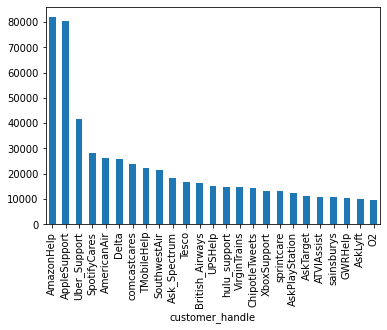

In [16]:
categorywise_count_for_graph.plot.bar()

In [17]:
categorywise_count.shape

(108,)

In [18]:
#query_df.to_excel("final_cleaned.xlsx")
#thresholdVal = 5000
#query_df=query_df[query_df.groupby("customer_handle")["author_id"].transform('size')>=thresholdVal]
query_df=query_df.drop(columns=["inbound","created_at","response_tweet_id","in_response_to_tweet_id"])
query_df=query_df[query_df["author_id"].str.isdigit()]
query_df["text"] = query_df["text"].str.strip()
query_df["followup"] = query_df["followup"].str.strip()
query_df["solution"] = query_df["solution"].str.strip()
query_df=query_df[query_df["text"]!=""]

query_df.to_excel("final_cleaned_filtered.xlsx")

In [33]:
query_df["customer_handle"].value_counts()

AmazonHelp         80495
AppleSupport       80007
Uber_Support       41603
SpotifyCares       28061
Delta              25822
                   ...  
AskDSC               197
mediatemplehelp      171
CarlsJr              150
HotelTonightCX       123
OfficeSupport         91
Name: customer_handle, Length: 108, dtype: int64

In [34]:
import os
import pandas as pd
import numpy as np

os.getcwd()
os.chdir("/content/drive/MyDrive/Learning/bigspring_assignment/twitter_cs/")


In [35]:
query_df=pd.read_excel("final_cleaned_filtered.xlsx")
query_df=query_df.set_index("tweet_id")
query_df=query_df[~pd.isnull(query_df["text"])]
query_df=query_df.fillna("")

In [36]:
query_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783574 entries, 8 to 2987950
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   author_id        783574 non-null  int64 
 1   text             783574 non-null  object
 2   followup         783574 non-null  object
 3   solution         783574 non-null  object
 4   customer_handle  783574 non-null  object
dtypes: int64(1), object(4)
memory usage: 35.9+ MB


In [37]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [38]:
import itertools

def create_word_list(row):
  all_tokens = []
  tokens = sent_tokenize(row.text)
  tokens2 = sent_tokenize(row.followup)
  tokens3 = sent_tokenize(row.solution)
  if tokens2:
    tokens.extend(tokens2)
  if tokens3:
    tokens.extend(tokens3)
  for sent in tokens:
    new_words = word_tokenize(sent)
    new_words=list(filter(str.isalnum, new_words))
    if new_words:
      all_tokens.append(new_words)
  row["word2vectrain"]=all_tokens
  return row

def process_columns(column):
  return list(itertools.chain.from_iterable(column))

In [39]:
query_df["word2vectrain"]=""
query_df=query_df.apply(create_word_list, axis=1)

In [40]:
query_df["merge_test"]=""
train_list = query_df.groupby("merge_test").word2vectrain.apply(process_columns)

In [41]:
import json
with open("word2vectraining.json","wt",encoding="utf8") as fp:
  json.dump(train_list[0], fp)

In [42]:
query_df.shape

(783574, 7)

In [43]:
!pip install wget
!pip install gensim

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=ec8ad9bce28eff5a5794c02798e56dca49e1d380d32d75cbdb3dacb8c31964f7
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [1]:
import os
import wget
import gzip
import shutil
import json
os.chdir("/content/drive/MyDrive/Learning/bigspring_assignment/twitter_cs/")
with open("word2vectraining.json","rt",encoding="utf8") as fp:
  sentences=json.load(fp)


gn_vec_path = "/content/GoogleNews-vectors-negative300.bin"
gn_vec_zip_path = "/content/GoogleNews-vectors-negative300.bin.gz"

if not os.path.exists(gn_vec_path):
  if not os.path.exists(gn_vec_zip_path):
    wget.download("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz","/content/")
    with gzip.open(gn_vec_zip_path, 'rb') as f_in:
      with open(gn_vec_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
  else:
    with gzip.open(gn_vec_zip_path, 'rb') as f_in:
      with open(gn_vec_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print(f"Model at {gn_vec_path}")

Model at /content/GoogleNews-vectors-negative300.bin


In [2]:
from gensim.models import Word2Vec, KeyedVectors
import io

In [3]:
len(sentences)

4392268

In [4]:
word2vec_model = Word2Vec(size = 300)

In [5]:
word2vec_model.build_vocab(sentences)

In [6]:
word2vec_model.intersect_word2vec_format(gn_vec_path, lockf=1.0, binary=True)

In [7]:
word2vec_model.train(sentences, total_examples=len(sentences), epochs = 5)

(154825191, 216163195)

In [8]:
weights = word2vec_model.wv.vectors
#vocab = word2vec_model.index2word
vocab = word2vec_model.wv.index2word

In [9]:
len(vocab)

51888

In [10]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()


In [11]:
word2vec_model.most_similar('to')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('and', 0.4837303161621094),
 ('when', 0.4553842544555664),
 ('then', 0.43360960483551025),
 ('will', 0.4170472025871277),
 ('unless', 0.4098970890045166),
 ('if', 0.3973616361618042),
 ('i', 0.38653653860092163),
 ('before', 0.38068073987960815),
 ('also', 0.36886653304100037),
 ('amp', 0.36398470401763916)]

In [12]:
word2vec_model['computer']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 2.08937573e+00, -1.93909121e+00,  4.58976366e-02,  1.27546465e+00,
       -7.53119290e-01,  8.06762502e-02,  7.75118411e-01,  1.25379944e+00,
        1.34833670e+00,  1.27956533e+00,  3.54163557e-01, -6.02699108e-02,
        7.72095978e-01,  5.06514370e-01,  1.18019986e+00,  3.13501984e-01,
        2.67885774e-01,  2.13308454e-01,  8.60503376e-01, -3.81577104e-01,
        6.87287390e-01,  1.59580672e+00,  1.41817534e+00, -2.27526249e-03,
        1.40637428e-01, -1.02538690e-01,  3.77418369e-01,  1.46987581e+00,
        4.84826088e-01, -5.73469043e-01, -9.09812927e-01,  9.46880504e-02,
       -2.18653321e+00, -8.16315830e-01, -1.72880411e+00, -1.50154114e+00,
       -2.81911314e-01,  5.34344792e-01,  2.03949869e-01, -1.62689197e+00,
        8.71677279e-01,  5.77825546e-01,  1.90421748e+00,  7.74347425e-01,
       -2.56223202e-01,  5.03253758e-01, -6.70913458e-02,  7.71198690e-01,
        5.43848157e-01, -1.42897308e+00, -5.61217666e-01,  8.32529515e-02,
        5.18005669e-01, -

In [13]:
#word2vec_model['I am ismail']

In [14]:
# http://projector.tensorflow.org/